In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
from scipy.interpolate import interp1d

import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
from pitszi import utils

# Simple test case

(12.262904434553825, 391.63961855115593)

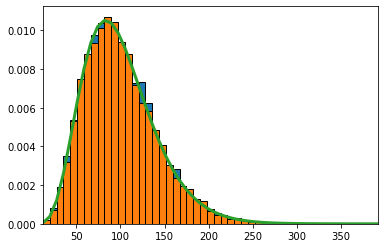

In [2]:
Nmc = 10000
mu = 0
sig = 5
Ncbin = 3 # Number of counts in the bin

# MC realization
pk_stat_i = np.zeros((Ncbin, Nmc))
for ibin in range(Ncbin):
    f1 = np.random.normal(mu,sig, Nmc)
    f2 = np.random.normal(mu,sig, Nmc)
    f3 = np.random.normal(mu,sig, Nmc)
    f4 = np.random.normal(mu,sig, Nmc)
    pk_stat_i[ibin,:] = f1**2 + f2**2 + f3**2 + f4**2
    
# Average in the bin
pk_stat = np.mean(pk_stat_i, axis=0)

# MC realization
bins = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
plt.hist(pk_stat, bins=bins, density=True, ec='k')

# Model prediction Nbin
xsample = np.linspace(np.amin(pk_stat)*0.8/sig**2*(Ncbin), 
                      np.amax(pk_stat)*1.2/sig**2*(Ncbin), 50)
pdf = scipy.stats.chi2.pdf(xsample, df=4*Ncbin)
dist = scipy.stats.chi2.rvs(df=4*Ncbin, size=Nmc)*sig**2/Ncbin
plt.hist(dist, bins=bins, density=True, ec='k')
plt.plot(xsample*sig**2/(Ncbin), pdf/sig**2*Ncbin, lw=3)
plt.xlim(np.amin(bins),np.amax(bins))

# Bining in k with FFT

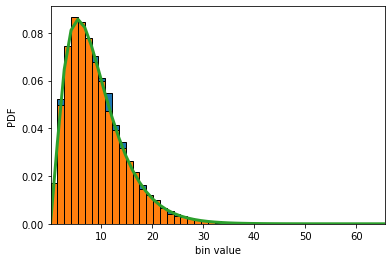

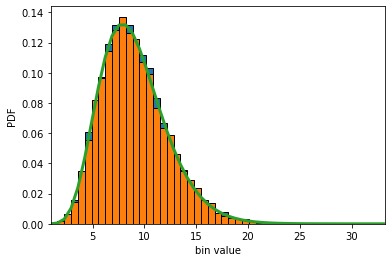

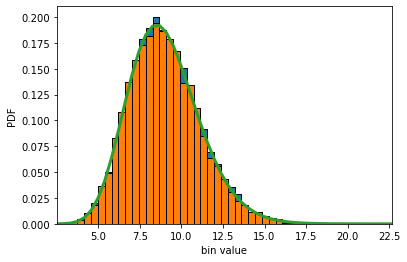

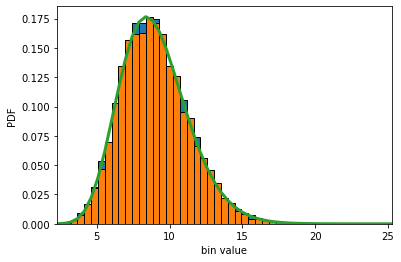

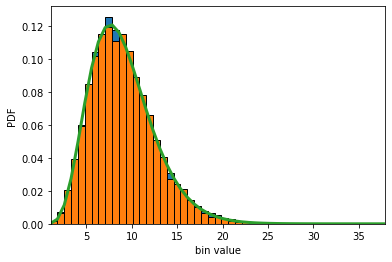

In [3]:
Nmc = 10000
Naxis = 10
reso = 1
mu = 0
sig = 3
Nbin = 5

# Fourier modes
kx = np.fft.fftfreq(Naxis, reso)
ky = np.fft.fftfreq(Naxis, reso)
k2d_x, k2d_y = np.meshgrid(kx, ky, indexing='ij')
k2d_norm = np.sqrt(k2d_x**2 + k2d_y**2)

# Binning in k
kbins = np.linspace(np.amin(k2d_norm), np.amax(k2d_norm), Nbin+1)
kbin_counts, _, _ = stats.binned_statistic(k2d_norm.flatten(), k2d_norm.flatten(), statistic='count', bins=kbins)

# MC realization
pk_stat_i = np.zeros((Nmc, Nbin))
for iMC in range(Nmc):
    field = np.random.normal(mu, sig, (Naxis,Naxis))
    Pk2d = np.abs(np.fft.fftn(field))**2 * reso**2/Naxis**2
    Pk2d_bin, _, _ = stats.binned_statistic(k2d_norm.flatten(), Pk2d.flatten(), statistic='mean', bins=kbins)
    pk_stat_i[iMC, :] = Pk2d_bin
    
# Plot for all k bins
for ib in range(Nbin):
    plt.figure(ib)
    pk_stat = pk_stat_i[:,ib]
    count = kbin_counts[ib]
    bins = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    plt.hist(pk_stat, bins=bins, density=True, ec='k')
    
    xsample = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    pdf = scipy.stats.chi2.pdf(xsample, df=count, scale=sig**2/count)
    dist = scipy.stats.chi2.rvs(df=count, scale=sig**2/count, size=Nmc)
    plt.hist(dist, bins=bins, density=True, ec='k')
    plt.plot(xsample, pdf, lw=3)
    plt.xlim(np.amin(bins),np.amax(bins))
    plt.xlabel('bin value')
    plt.ylabel('PDF')

# With the use of realistic power spectrum

In [4]:
def input_pk(k):
    return amp*(k/k0)**alpha * np.exp(-(1/(k*Linj)**2))

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


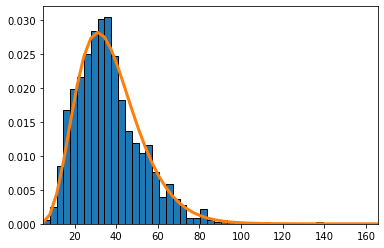

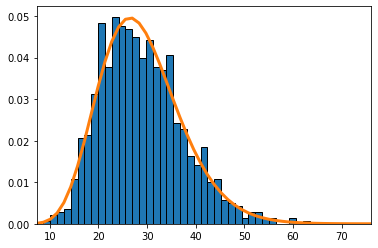

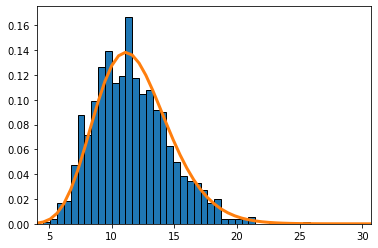

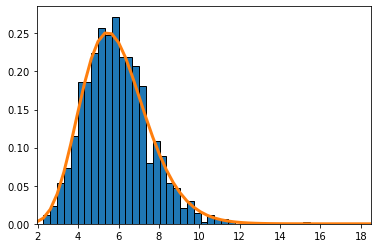

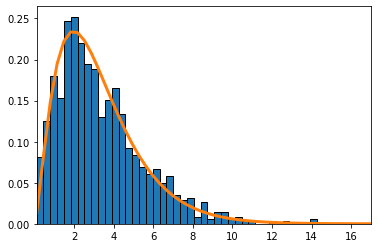

In [5]:
Nmc = 1000
Naxis = 10
reso = 1
Nbin = 5

alpha = -3
k0 = 1
amp = 1.0
Linj = 5

# Fourier modes
kx = np.fft.fftfreq(Naxis, reso)
ky = np.fft.fftfreq(Naxis, reso)
k2d_x, k2d_y = np.meshgrid(kx, ky, indexing='ij')
k2d_norm = np.sqrt(k2d_x**2 + k2d_y**2)

# Binning in k
kbins = np.linspace(np.amin(k2d_norm[k2d_norm>0]), np.amax(k2d_norm), Nbin+1)
kbin_counts, _, _ = stats.binned_statistic(k2d_norm.flatten(), k2d_norm.flatten(), statistic='count', bins=kbins)
kctr = (0.5 * (kbins[1:] + kbins[:-1]))

# MC realization
pk_stat_i = np.zeros((Nmc, Nbin))
for iMC in range(Nmc):
    #build the field
    field = np.random.normal(0, 1, (Naxis,Naxis))
    FFTfield = np.fft.fftn(field)
    amplitude = input_pk(k2d_norm)
    amplitude[k2d_norm == 0] = 0
    amplitude = np.sqrt(amplitude / (reso**2))
    field = np.real(np.fft.ifftn(FFTfield * amplitude))
    
    # extract Pk
    Pk2d = np.abs(np.fft.fftn(field))**2 * reso**2/Naxis**2
    Pk2d_bin, _, _ = stats.binned_statistic(k2d_norm.flatten(), Pk2d.flatten(), statistic='mean', bins=kbins)
    pk_stat_i[iMC, :] = Pk2d_bin
    
# Compute the average sigma^2 for the bin, to be plugged in chi2 distribution (scale)
sigma2, _, _ = stats.binned_statistic(k2d_norm.flatten(), input_pk(k2d_norm.flatten()), 
                                      statistic='mean', bins=kbins)
# Plot for all k bins
for ib in range(Nbin):
    plt.figure(ib)
    pk_stat = pk_stat_i[:,ib]
    count = kbin_counts[ib]

    sig = sigma2[ib]**0.5
    
    bins = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    plt.hist(pk_stat, bins=bins, density=True, ec='k')
    
    xsample = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    pdf = scipy.stats.chi2.pdf(xsample, df=count, scale=sig**2/count)
    #dist = scipy.stats.chi2.rvs(df=count, scale=sig**2/count, size=Nmc)
    #plt.hist(dist, bins=bins, density=True, ec='k', alpha=0.3)
    plt.plot(xsample, pdf, lw=3)
    plt.xlim(np.amin(bins),np.amax(bins))

Text(0, 0.5, 'Pk')

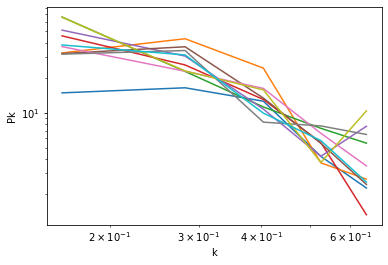

In [6]:
kvals = 0.5 * (kbins[1:] + kbins[:-1])
for iMC in range(10):
    plt.loglog(kvals, pk_stat_i[iMC,:])
plt.xlabel('k')
plt.ylabel('Pk')

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


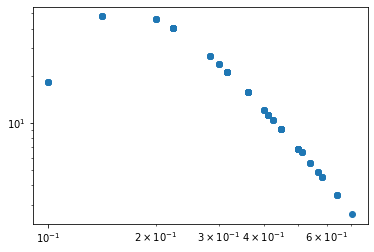

In [7]:
plt.loglog(k2d_norm.flatten(), input_pk(k2d_norm.flatten()), ls='', marker='o')

# Check that the covariance is diagonal for binned Pk without mask

In [8]:
Nmc=10000
Pkbin_MC = np.zeros((Nmc, Nbin))
for iMC in range(Nmc):
    #build the field
    field = np.random.normal(0, 1, (Naxis,Naxis))
    FFTfield = np.fft.fftn(field)
    amplitude = input_pk(k2d_norm)
    amplitude[k2d_norm == 0] = 0
    amplitude = np.sqrt(amplitude / (reso**2))
    field = np.real(np.fft.ifftn(FFTfield * amplitude))
    
    # extract Pk
    Pk2d = np.abs(np.fft.fftn(field))**2 * reso**2/Naxis**2
    Pk2d_bin, _, _ = stats.binned_statistic(k2d_norm.flatten(), Pk2d.flatten(), statistic='mean', bins=kbins)
    Pkbin_MC[iMC,:] = Pk2d_bin
Pkbin_mean = np.mean(Pkbin_MC, axis=0)
    
cov = np.zeros((Nbin, Nbin))
for iMC in range(Nmc):
    cov += np.matmul((Pkbin_MC[iMC,:] - Pkbin_mean)[:,None], (Pkbin_MC[iMC,:] - Pkbin_mean)[None,:])
cov /= Nmc

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


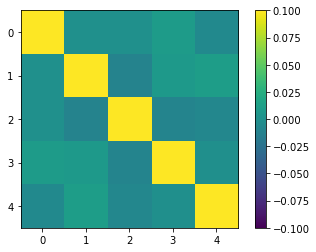

In [9]:
plt.imshow(utils.correlation_from_covariance(cov), vmin=-0.1, vmax=0.1)
plt.colorbar()

# Mimicing a mask with coefficients 

#### First get sum of gamma fucntions

In [10]:
def sum_gamma_pdf(y, a, b, K=100):
    '''
    Modified from seongjaelee/moschopoulos.py
    Moschopoulos 1984: the distribution of the sum of independent gamma random variable
    '''
    
    # Make sure y is an array
    y = np.array(y)
    
    # constants
    b1  = np.amin(b)                                     # Below Eq 2.1
    rho = np.sum(a)                                      # Eq 2.5
    C   = np.prod([(b1/bi)**ai for ai, bi in zip(a, b)]) # Eq 2.4
     
    # Eq 2.5
    gamma = [0] + [np.sum([ai * (1.0 - b1/bi)**k / k for ai, bi in zip(a, b)]) for k in range(1, K+1)]
    
    # Eq 2.8
    delta = [1 for k in range(K+1)]
    for k in range(1, K+1):
        delta[k] = 1.0/k * np.sum([i * gamma[i] * delta[k-i] for i in range(1, k+1)])
 
    # Define sum log and interpolate to non integer
    sumlog = [0.0]
    for i in range(1, int(rho+K+1)): sumlog.append(sumlog[-1] + np.log(i))
    sl_itpl = interp1d(np.linspace(0, int(rho+K), int(rho+K+1)), np.array(sumlog))

    # result is 0 for y=0
    res = np.zeros(len(y))

    # Compute result for y > 0
    w = (y > 0)
    ybis = y[w]
    #--- The naive form below does not work because it gives inf quickly. It is malaxed a bit to make it work
    #respos = C * np.sum([delta[k] * ybis**(rho+k-1) * np.exp(-ybis/b1) / (scipy.special.gamma(rho+k)*b1**(rho+k)) for k in range(K)], axis=0)
    #--- Original version for rho = integer only
    #respos = C * np.sum([delta[k] * np.exp(-ybis/b1)/ b1 * np.exp((rho+k-1) * np.log(ybis/b1) - sumlog[int(rho+k-1)]) for k in range(K)], axis=0)
    #--- Final version
    respos = C * np.sum([delta[k] * np.exp(-ybis/b1)/ b1 * np.exp((rho+k-1) * np.log(ybis/b1) - sl_itpl(rho+k-1)) for k in range(K)], axis=0)
    #respos = np.sum([C*delta[k]/b1 * np.exp((rho+k-1) * np.log(ybis/b1) - sl_itpl(rho+k-1) - ybis/b1) for k in range(K)], axis=0)
    res[w] = respos
    
    return res

No handles with labels found to put in legend.


Computing time (s): 0.2512197494506836


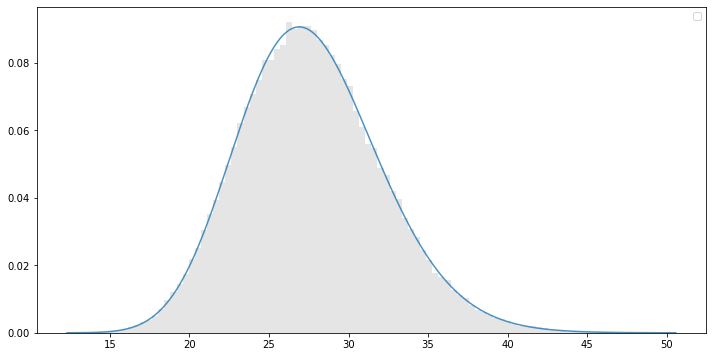

In [13]:
Nvar = 10
Ncounts = 10
a,b = np.random.uniform(Ncounts/2, Ncounts/2, Nvar), np.random.uniform(0, 1, Nvar)
#a,b = np.array([0.5,1]), np.array([1,1])
ns = 100000
data = 0
for ai, bi in zip(a, b):
    data += stats.gamma.rvs(ai, scale=bi, size=ns)

x = np.linspace(np.amin(data), np.amax(data), 1000)
start = time.time()
model = sum_gamma_pdf(x, a, b, K=1000)
end = time.time()
print('Computing time (s):', end - start)

plt.figure(figsize=(12, 6))
plt.hist(data, bins=100, range=(np.amin(data), np.amax(data)), density=True, color='k', alpha=.1)
plt.plot(x, model, linewidth=1.5, alpha=.8)
plt.legend()
#model

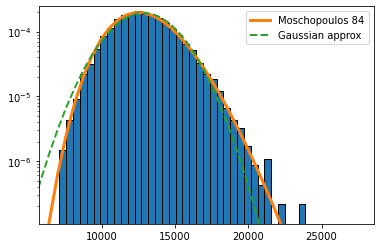

In [21]:
from scipy.stats import ncx2, gamma

Nmc = 10000
sig = 5
coeff = np.random.uniform(1,10, 100) # Assumes sum of 20 variables

# MC realization
pk_stat = 0
for i in range(len(coeff)):
    pk_stat += coeff[i] * np.random.normal(0, sig, Nmc)**2

# MC realization
bins = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
nhist, bhist, phist = plt.hist(pk_stat, bins=bins, density=True, ec='k')

# Model prediction Nbin
xsample = np.linspace(0, np.amax(pk_stat)*1.2, 50)

alpha = np.ones(len(coeff))/2
beta  = 2*sig**2*coeff
# Moschopoulos method
pdf = sum_gamma_pdf(xsample, alpha, beta, K=1000)
# Gaussian approx: mean = sum of means, var = sum var_i, with var_i = 2x(sig**2*coeff)**2
pdf_g = scipy.stats.norm.pdf(xsample, np.sum(coeff)*sig**2, (np.sum((sig**2*coeff*2**0.5)**2))**0.5)

plt.plot(xsample, pdf, lw=3, label='Moschopoulos 84')
plt.plot(xsample, pdf_g, lw=2, ls='--', label='Gaussian approx')
plt.xlim(np.amin(bins),np.amax(bins))
plt.yscale('log')
plt.ylim(np.amin(nhist[nhist>0])/2, np.amax(nhist)*1.2)
plt.legend()